## Clustering Restaurants Based on Customer Typology and Revenue Behavior

<img src="clustering-clients.webp" alt="clustering-clients" width="350">

*packages*

In [1]:
# packages
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import os, yaml, requests
np.random.seed(42)

# scikit learn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


*functions*

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

*create the connection to the db*

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

*get all the data from the db*

In [4]:
q = """
    select
            *
    from
            kaggle_data.revenue_forecast.data;
"""

df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763


In [5]:
df=df_raw.copy()

*encoding data*

In [6]:
ordinal_encoder=OrdinalEncoder()
df['cuisine_encode']=ordinal_encoder.fit_transform(df[['Cuisine_Type']])
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.91204,2.0


In [7]:
cuisine_type=df[['Cuisine_Type', 'cuisine_encode']].drop_duplicates(inplace=False)
cuisine_type

,Cuisine_Type,cuisine_encode
0,Japanese,2.0
1,Italian,1.0
5,American,0.0
10,Mexican,3.0


In [8]:
cols=['Cuisine_Type']
df.drop(columns=cols,inplace=True)
df.head(2)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode
0,61,43.117635,12.663793,36.236133,0,45,350.912040,2.0
1,24,40.020077,4.577892,17.952562,0,36,221.319091,1.0


*scaling data*

Before proceeding with clustering, we need to scale the data. This step is crucial because it ensures that all features contribute equally to the results. Here's why:

1. **Equal Weight**: Features in our data may have different units and ranges. Without scaling, features with larger values can dominate the clustering process, skewing the results.
  
2. **Improved Accuracy**: Scaling standardizes the data, typically giving each feature a mean of 0 and a standard deviation of 1. This allows clustering algorithms like K-means to accurately identify patterns and group similar data points.

3. **Distance Calculation**: Clustering algorithms often use distance measures, such as Euclidean distance, to determine similarity between data points. Scaling ensures that no single feature disproportionately influences these distances.

In [9]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

**`clustering k-means`**

In [10]:
clusters = [2, 3, 4, 5, 7, 10]
kmeans_per_k = [KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 42).fit(df_scaled)
                for k in clusters]
inertias = [model.inertia_ for model in kmeans_per_k]

*`inertias`*

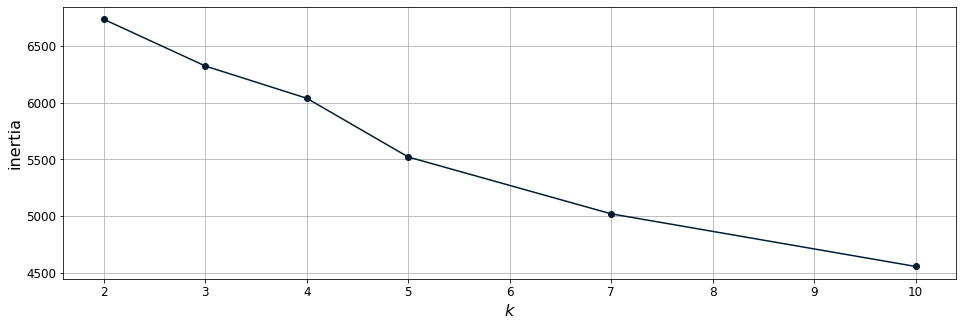

In [11]:
plt.figure(figsize = (16,5))
plt.plot(clusters, inertias, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("inertia", fontsize = 16)
plt.grid(True)
plt.show()

*`silhouette score`*

In [12]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_)
                     for model in kmeans_per_k]

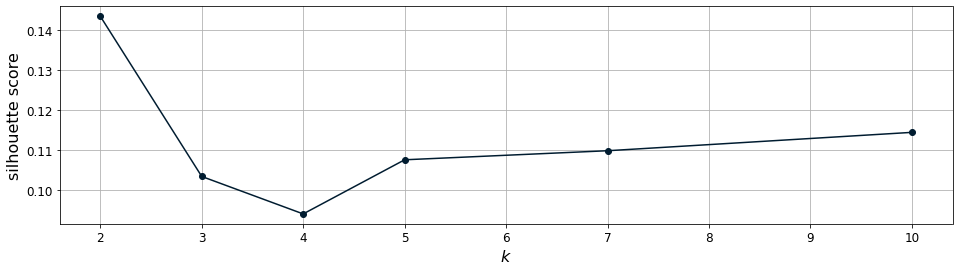

In [13]:
plt.figure(figsize = (16,4))
plt.plot(clusters, silhouette_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("silhouette score", fontsize = 16)
plt.grid(True)
plt.show()

*`davies-bouldin score`*

In [14]:
davies_bouldin_scores = [davies_bouldin_score(df_scaled, model.labels_)
                         for model in kmeans_per_k]

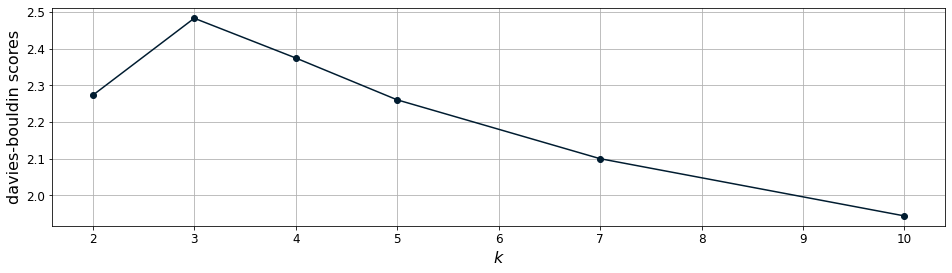

In [15]:
plt.figure(figsize = (16,4))
plt.plot(clusters, davies_bouldin_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("davies-bouldin scores", fontsize = 16)
plt.grid(True)
plt.show()

*`calinski-harabasz score score`*

In [16]:
calinski_harabasz_scores = [calinski_harabasz_score(df_scaled, model.labels_)
                            for model in kmeans_per_k]

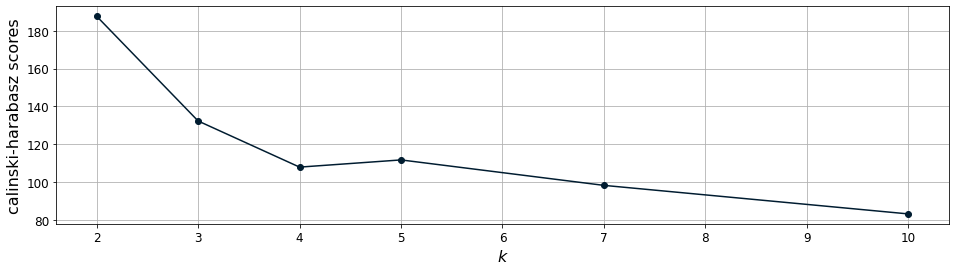

In [17]:
plt.figure(figsize = (16,4))
plt.plot(clusters, calinski_harabasz_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("calinski-harabasz scores", fontsize = 16)
plt.grid(True)
plt.show()

# text

In [18]:
k = 5
kmeans = KMeans(n_clusters = k, 
                init = 'k-means++', 
                n_init = 'auto', 
                random_state = 42)

y_pred = kmeans.fit_predict(df_scaled)

In [19]:
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
db_score = davies_bouldin_score(df_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans.labels_)

print(f"K-means inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

K-means inertia: 5521.6754974732285
Silhouette Score: 0.1076320786923985
Davies-Bouldin Score: 2.2603565925981464
Calinski-Harabasz Score: 111.64785404097798


In [20]:
df['cluster'] = kmeans.labels_
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,cluster
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,4


In [21]:
df=df.merge(cuisine_type, on='cuisine_encode', how='left')
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,cluster,Cuisine_Type
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,4,Japanese


In [22]:
df['cluster'].unique()

array([4, 0, 1, 2, 3])

In [23]:
df['cluster'].value_counts()

2    235
1    214
4    210
0    192
3    149
Name: cluster, dtype: int64

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


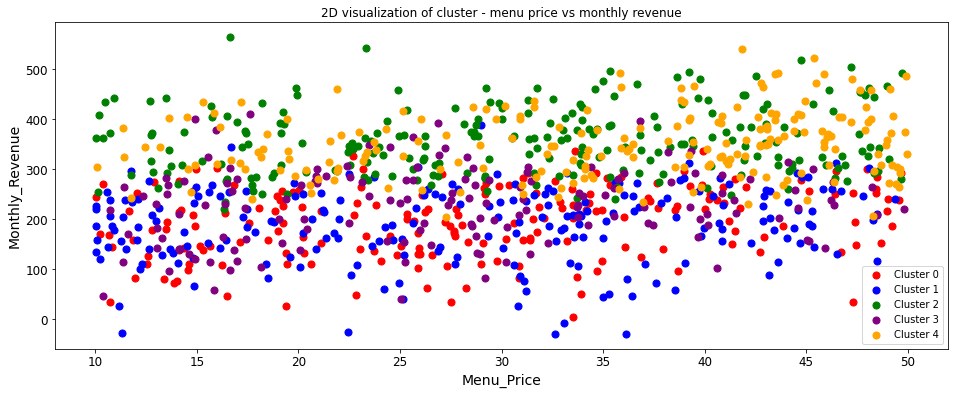

In [24]:
fig, ax = plt.subplots(figsize=(16,6))
colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

cols=['Menu_Price', 'Monthly_Revenue', 'cluster']
for cluster, group in df[cols].groupby('cluster'):
    group.plot(ax=ax, 
               kind='scatter', 
               x='Menu_Price', 
               y='Monthly_Revenue', 
               s=50,
               label=f'Cluster {cluster}', 
               color=colors[cluster])

plt.title('2D visualization of cluster - menu price vs monthly revenue')
plt.show()

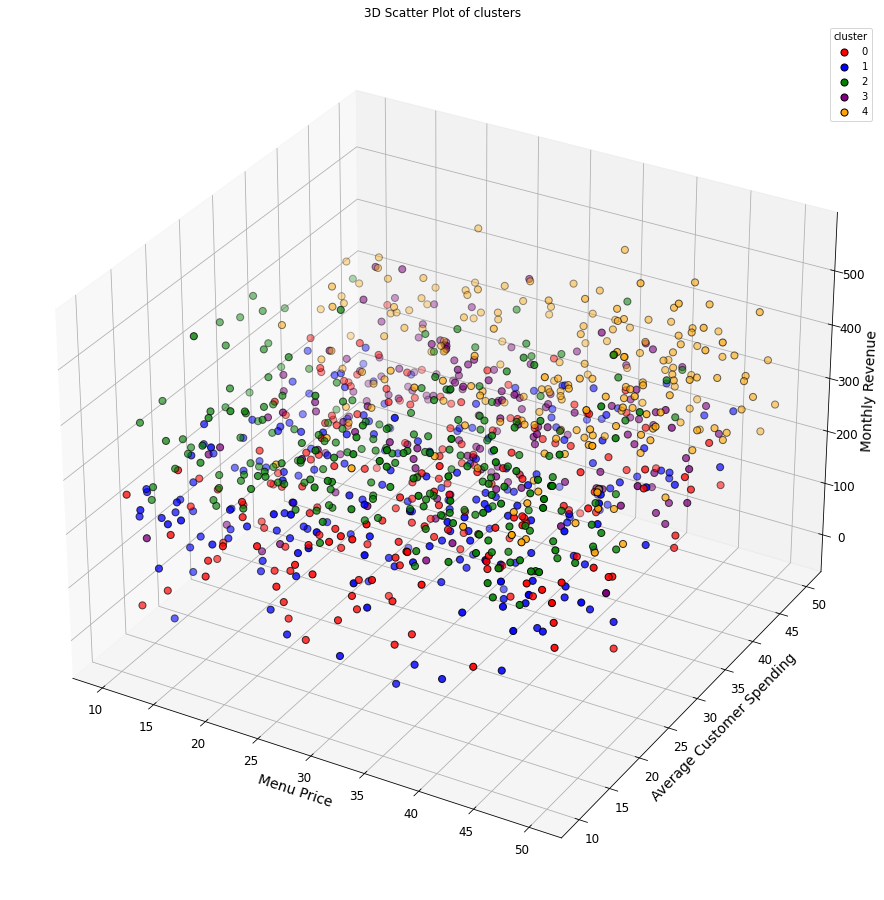

In [25]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

for cluster, group in df.groupby('cluster'):
    ax.scatter(group['Menu_Price'], 
               group['Average_Customer_Spending'], 
               group['Monthly_Revenue'], 
               c=colors[cluster], 
               label=cluster, 
               s=50, 
               edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of clusters')
ax.legend(title='cluster')
plt.show()

The clusters for revenue versus menu price clearly split based on the revenue of each site, which is expected. However, according to the metrics above, these clusters are underperforming.

*`new features`*

In [26]:
df.drop(columns=['cluster'],inplace=True)
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,Japanese


Customer Spending Ratio:
- Calculate the marketing expenditure per customer. This metric can reveal how efficiently marketing resources are being used to attract customers.

In [27]:
df['marketing_spend_per_customer'] = df['Marketing_Spend'] / df['Number_of_Customers']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,Japanese,0.207603


Customer Profitability:
- This metric reflects the revenue generated by each customer. It is useful for identifying the value of customers in terms of their contribution to total revenue.

In [28]:
df['revenue_per_customer'] = df['Monthly_Revenue'] / df['Number_of_Customers']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,Japanese,0.207603,5.752656


Review-to-Revenue Conversion Ratio:
- Examine the relationship between the number of reviews and monthly revenue. A high ratio could indicate a strong influence of reviews on revenue, which can be useful for segmenting customers based on market response.

In [29]:
df['reviews_to_revenue_ratio'] = df['Monthly_Revenue'] / df['Reviews']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,Japanese,0.207603,5.752656,7.798045


Spend Efficiency:
- Calculate the efficiency of marketing spend by comparing marketing expenses with monthly revenue. A higher value may indicate greater efficiency in converting marketing spend into revenue.

In [30]:
df['marketing_efficiency'] = df['Monthly_Revenue'] / df['Marketing_Spend']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,Japanese,0.207603,5.752656,7.798045,27.70987


Menu Price Ratio:
- Compare the menu price with the average customer spending. A value greater than 1 could indicate that customers are willing to pay more than the average menu price, suggesting a less price-sensitive clientele.

In [31]:
df['relative_menu_price'] = df['Average_Customer_Spending'] / df['Menu_Price'] 
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,Japanese,0.207603,5.752656,7.798045,27.70987,0.840402


*drop Cuisine Type*

In [32]:
df.drop(columns=['Cuisine_Type'], inplace=True)

In [33]:
df.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172,1.506000,0.272909,5.952150,inf,123.747311,1.163386
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950,1.123934,0.287215,3.195084,NaN,1025.080620,0.742365
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809,0.000000,0.000198,-2.761028,-2.410074,-35.653095,0.215908
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642,0.000000,0.089605,4.082428,3.275355,17.850756,0.650949
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964,2.000000,0.187675,5.123055,5.501988,27.244532,0.965697
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793,2.250000,0.338985,6.801814,11.373713,53.624091,1.435539
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332,3.000000,1.756806,26.167213,inf,29425.463498,4.485616


In [34]:
df.loc[np.isinf(df['reviews_to_revenue_ratio'])]

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
30,69,29.816945,0.852664,32.954024,1,0,203.959352,1.0,0.012357,2.955933,inf,239.202438,1.105211
179,86,46.424960,14.990910,33.113119,1,0,340.626718,0.0,0.174313,3.960776,inf,22.722218,0.713261
458,25,41.552279,15.184975,27.234331,0,0,212.936556,0.0,0.607399,8.517462,inf,14.022846,0.655423
543,95,36.279354,2.633869,37.847698,0,0,339.617381,2.0,0.027725,3.574920,inf,128.942408,1.043230
768,59,16.737775,18.374694,47.555079,0,0,256.393288,2.0,0.311435,4.345649,inf,13.953608,2.841183


*replace inf values*

In [35]:
df.loc[np.isinf(df['reviews_to_revenue_ratio']), 'reviews_to_revenue_ratio'] = 0

In [36]:
df.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172,1.506000,0.272909,5.952150,14.330490,123.747311,1.163386
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950,1.123934,0.287215,3.195084,38.888497,1025.080620,0.742365
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809,0.000000,0.000198,-2.761028,-2.410074,-35.653095,0.215908
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642,0.000000,0.089605,4.082428,3.239839,17.850756,0.650949
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964,2.000000,0.187675,5.123055,5.450810,27.244532,0.965697
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793,2.250000,0.338985,6.801814,11.046557,53.624091,1.435539
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332,3.000000,1.756806,26.167213,447.230857,29425.463498,4.485616


*scaling data*

In [37]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

**`clustering k-means`**

In [38]:
clusters = [2, 3, 4, 5, 7, 10]
kmeans_per_k = [KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 42).fit(df_scaled)
                for k in clusters]
inertias = [model.inertia_ for model in kmeans_per_k]

*`inertias`*

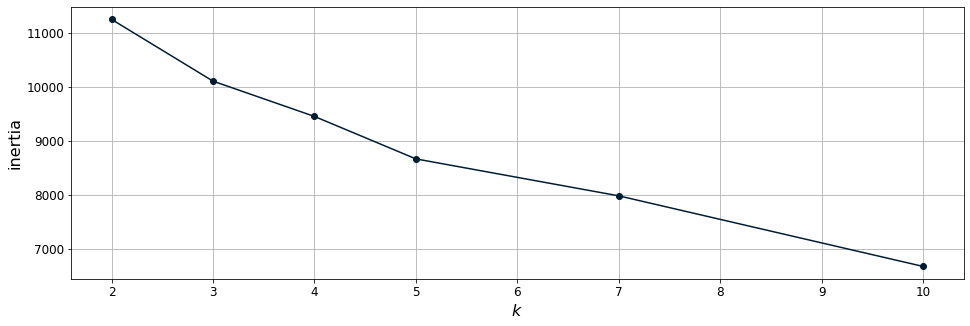

In [39]:
plt.figure(figsize = (16,5))
plt.plot(clusters, inertias, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("inertia", fontsize = 16)
plt.grid(True)
plt.show()

*`silhouette score`*

In [40]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_)
                     for model in kmeans_per_k]

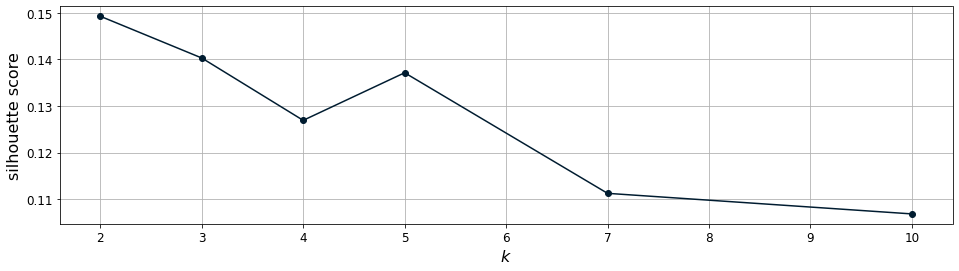

In [41]:
plt.figure(figsize = (16,4))
plt.plot(clusters, silhouette_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("silhouette score", fontsize = 16)
plt.grid(True)
plt.show()

*`davies-bouldin score`*

In [42]:
davies_bouldin_scores = [davies_bouldin_score(df_scaled, model.labels_)
                         for model in kmeans_per_k]

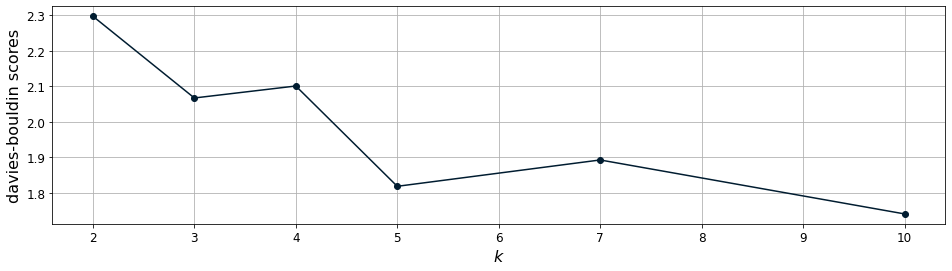

In [43]:
plt.figure(figsize = (16,4))
plt.plot(clusters, davies_bouldin_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("davies-bouldin scores", fontsize = 16)
plt.grid(True)
plt.show()

*`calinski-harabasz score score`*

In [44]:
calinski_harabasz_scores = [calinski_harabasz_score(df_scaled, model.labels_)
                            for model in kmeans_per_k]

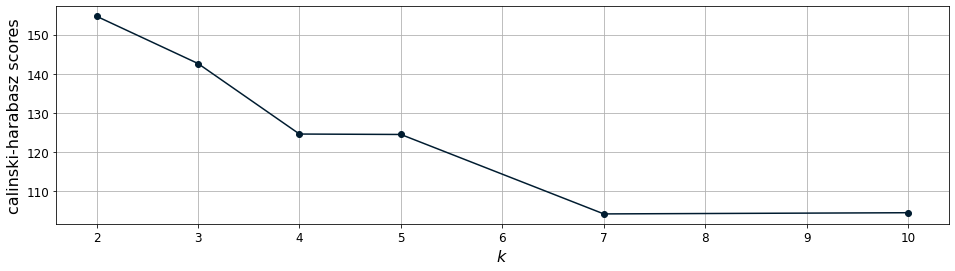

In [45]:
plt.figure(figsize = (16,4))
plt.plot(clusters, calinski_harabasz_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("calinski-harabasz scores", fontsize = 16)
plt.grid(True)
plt.show()

In [46]:
k = 3
kmeans = KMeans(n_clusters = k, 
                init = 'k-means++', 
                n_init = 'auto', 
                random_state = 42)

y_pred = kmeans.fit_predict(df_scaled)

In [47]:
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
db_score = davies_bouldin_score(df_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans.labels_)

print(f"K-means inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

K-means inertia: 10108.32545932856
Silhouette Score: 0.14028991638075947
Davies-Bouldin Score: 2.06729068988087
Calinski-Harabasz Score: 142.6085066434908


In [48]:
df['cluster'] = kmeans.labels_
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,0.207603,5.752656,7.798045,27.70987,0.840402,2


In [49]:
df=df.merge(cuisine_type, on='cuisine_encode', how='left')
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster,Cuisine_Type
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,0.207603,5.752656,7.798045,27.70987,0.840402,2,Japanese


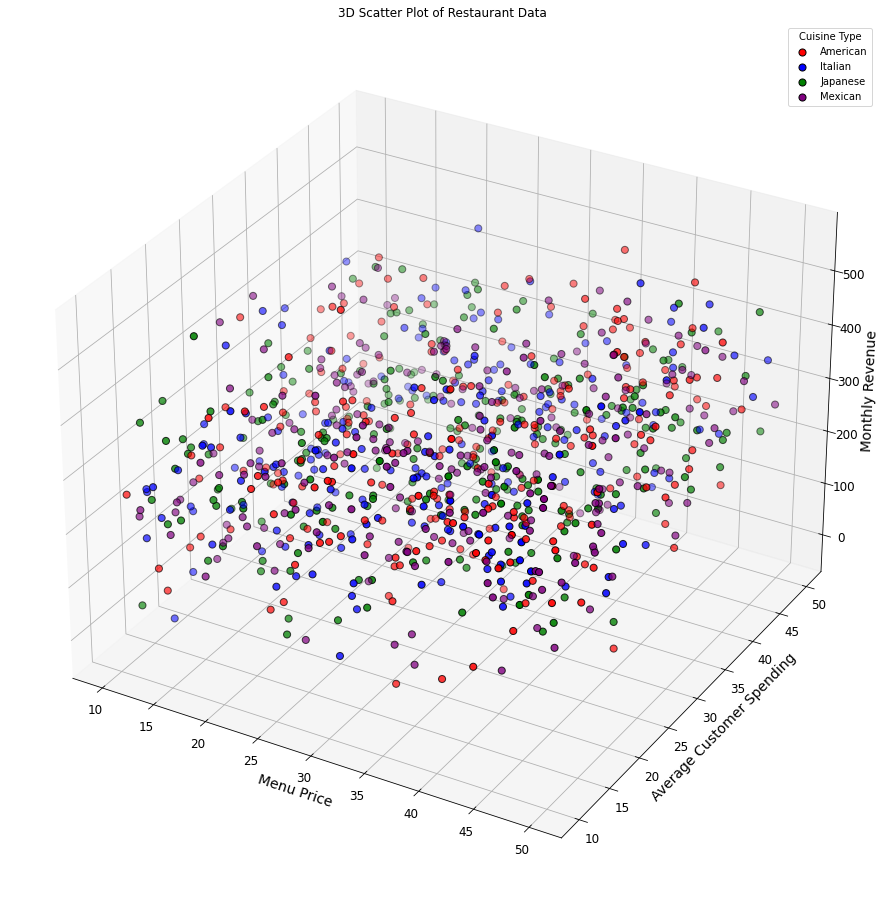

In [50]:
# Crear un gráfico 3D
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

# Colores para cada tipo de cocina
colors = {'American': 'red', 
          'Italian': 'blue', 
          'Japanese': 'green', 
          'Mexican': 'purple'}

# Agrupar por tipo de cocina y graficar
for cuisine, group in df.groupby('Cuisine_Type'):
    ax.scatter(group['Menu_Price'], group['Average_Customer_Spending'], group['Monthly_Revenue'], 
               c=colors[cuisine], label=cuisine, s=50, edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of Restaurant Data')
ax.legend(title='Cuisine Type')

plt.show()

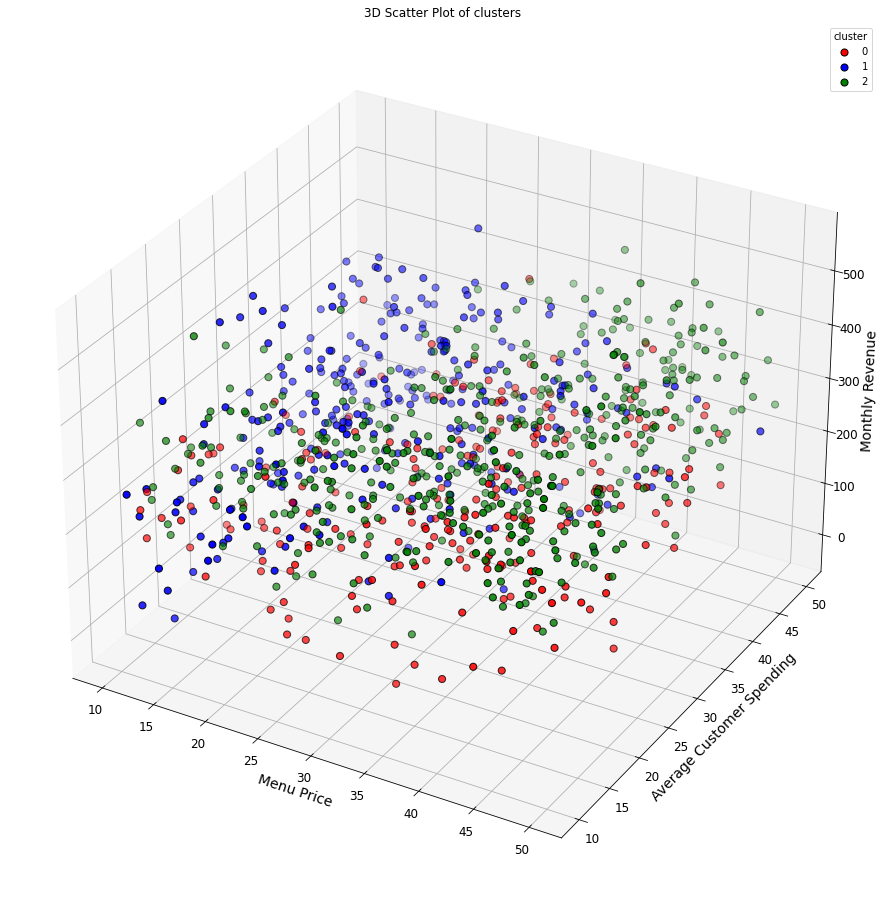

In [51]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

for cluster, group in df.groupby('cluster'):
    ax.scatter(group['Menu_Price'], 
               group['Average_Customer_Spending'], 
               group['Monthly_Revenue'], 
               c=colors[cluster], 
               label=cluster, 
               s=50, 
               edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of clusters')
ax.legend(title='cluster')
plt.show()

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


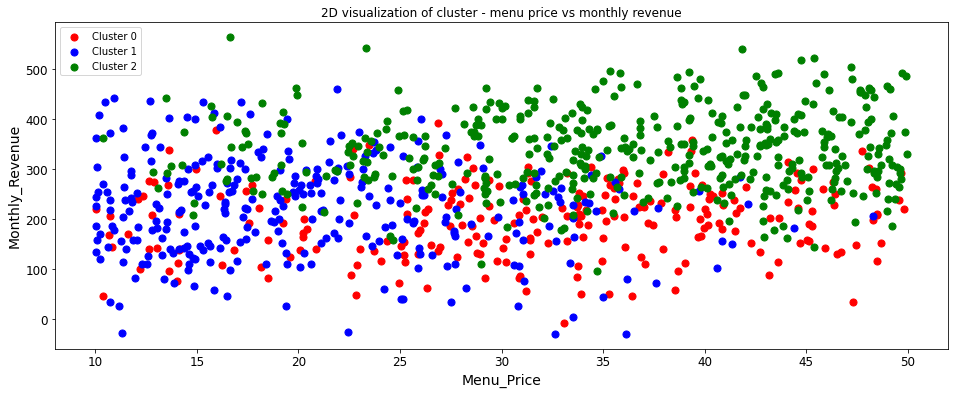

In [52]:
fig, ax = plt.subplots(figsize=(16,6))
colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

cols=['Menu_Price', 'Monthly_Revenue', 'cluster']
for cluster, group in df[cols].groupby('cluster'):
    group.plot(ax=ax, 
               kind='scatter', 
               x='Menu_Price', 
               y='Monthly_Revenue', 
               s=50,
               label=f'Cluster {cluster}', 
               color=colors[cluster])

plt.title('2D visualization of cluster - menu price vs monthly revenue')
plt.show()

*`monthly revenue by cluster`*

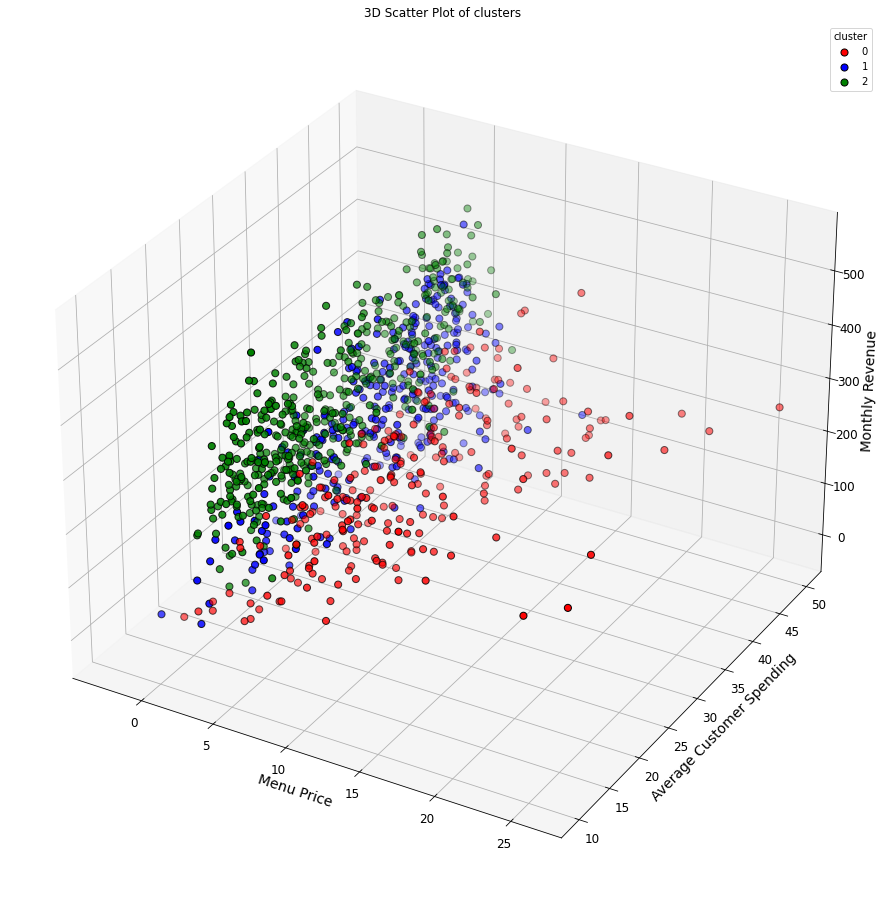

In [53]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

for cluster, group in df.groupby('cluster'):
    ax.scatter(group['revenue_per_customer'], 
               group['Average_Customer_Spending'], 
               group['Monthly_Revenue'], 
               c=colors[cluster], 
               label=cluster, 
               s=50, 
               edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of clusters')
ax.legend(title='cluster')
plt.show()

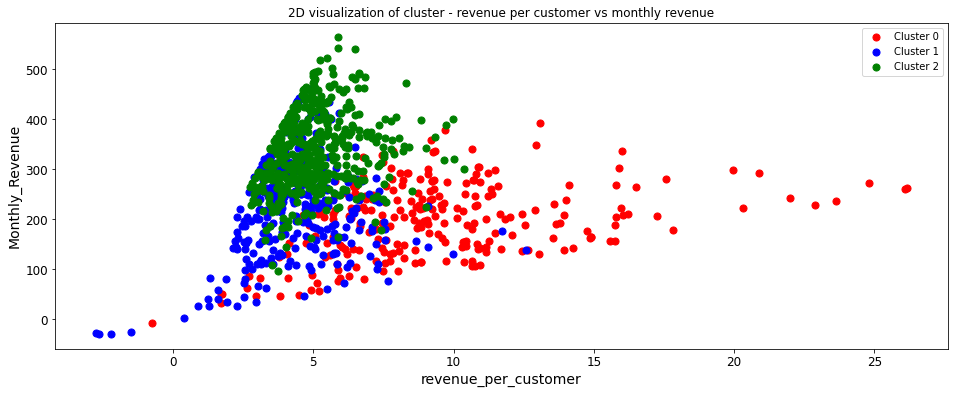

In [54]:
fig, ax = plt.subplots(figsize=(16,6))
colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

cols=['revenue_per_customer', 'Monthly_Revenue', 'cluster']
for cluster, group in df[cols].groupby('cluster'):
    group.plot(ax=ax, 
               kind='scatter', 
               x='revenue_per_customer', 
               y='Monthly_Revenue', 
               s=50,
               label=f'Cluster {cluster}', 
               color=colors[cluster])

plt.title('2D visualization of cluster - revenue per customer vs monthly revenue')
plt.show()

In [55]:
df['cluster'].value_counts()

2    455
1    302
0    243
Name: cluster, dtype: int64

**`customer behavior`**

*number of customers*

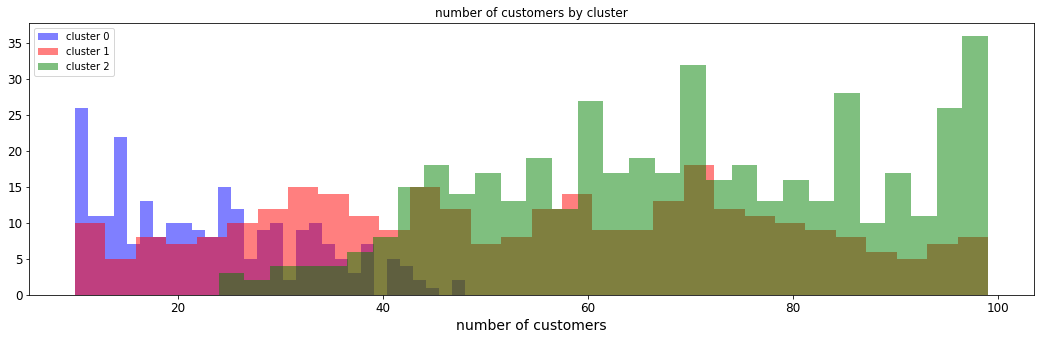

In [56]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Number_of_Customers'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('number of customers')
plt.title('number of customers by cluster')
plt.legend()
plt.show()

*menu price*

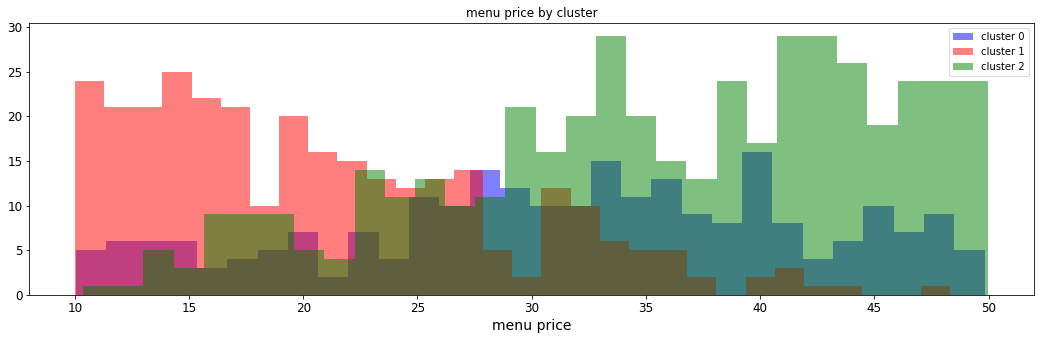

In [57]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Menu_Price'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('menu price')
plt.title('menu price by cluster')
plt.legend()
plt.show()

*marketing spend*

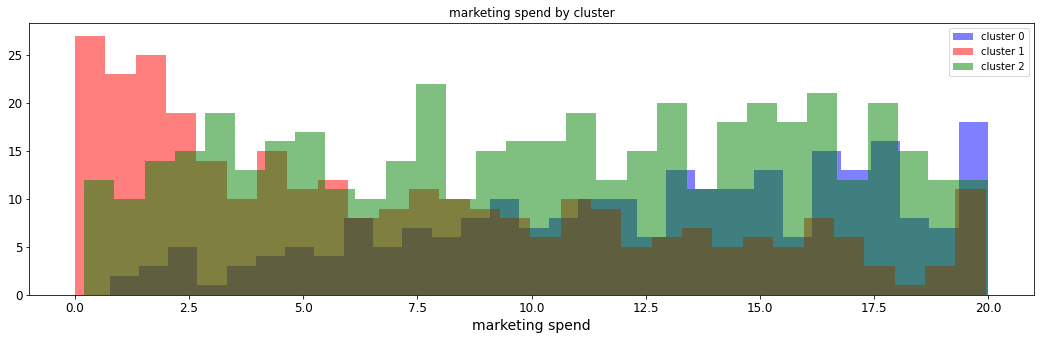

In [58]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Marketing_Spend'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('marketing spend')
plt.title('marketing spend by cluster')
plt.legend()
plt.show()

*avg customer spending*

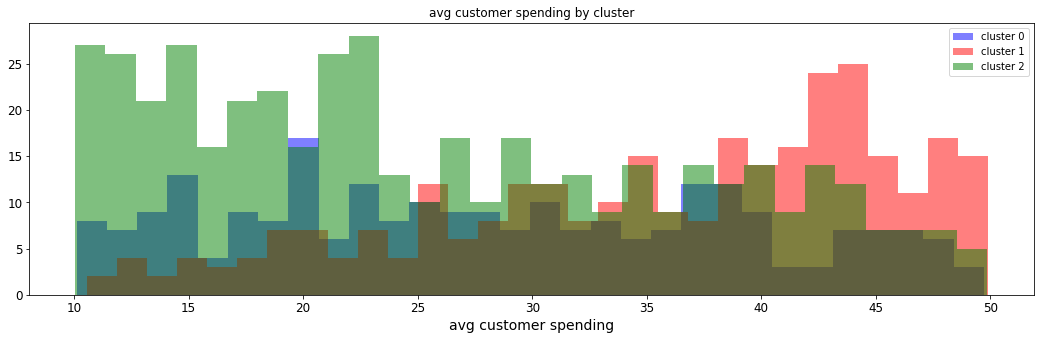

In [59]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Average_Customer_Spending'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('avg customer spending')
plt.title('avg customer spending by cluster')
plt.legend()
plt.show()

*monthly revenue*

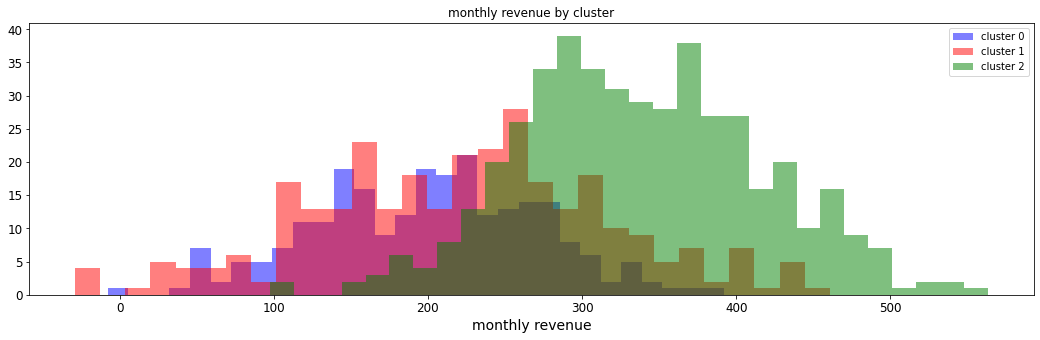

In [60]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Monthly_Revenue'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('monthly revenue')
plt.title('monthly revenue by cluster')
plt.legend()
plt.show()

*clusters describe*

In [61]:
condition=df['cluster']==0
df[condition].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.0
mean,22.971193,31.658845,12.669836,28.344827,0.411523,52.061728,198.624422,1.469136,0.630208,9.521385,8.057128,20.554107,1.004137,0.0
std,9.523524,10.194437,4.942512,10.815533,0.493125,28.950804,72.423045,1.084295,0.360861,4.193233,18.039289,19.900304,0.546571,0.0
min,10.000000,10.044804,0.760437,10.108326,0.000000,0.000000,-7.627382,0.000000,0.050696,-0.762738,-0.246045,-1.269160,0.231824,0.0
25%,15.000000,25.329803,9.133173,19.597304,0.000000,27.500000,144.359209,1.000000,0.387395,6.773456,2.412820,11.830197,0.606335,0.0
50%,22.000000,32.268863,13.502801,27.750854,0.000000,53.000000,204.020255,1.000000,0.544505,8.888811,3.727363,15.088096,0.911530,0.0
75%,30.000000,39.435314,16.816873,37.195951,1.000000,77.500000,249.378598,2.000000,0.758589,10.949465,7.391446,20.882200,1.244776,0.0
max,48.000000,49.819220,19.989325,49.717739,1.000000,99.000000,391.972850,3.000000,1.756806,26.167213,237.575904,171.236169,3.583066,0.0


In [62]:
condition=df['cluster']==1
df[condition].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.0
mean,53.771523,20.764029,7.121708,35.832190,0.533113,53.009934,221.617242,1.397351,0.155620,4.354398,7.677296,295.531428,1.914818,1.0
std,23.954084,7.992945,5.715263,9.863852,0.499730,28.544130,95.795390,1.129957,0.139714,1.772094,11.316928,1849.851645,0.779499,0.0
min,10.000000,10.009501,0.003768,10.575249,0.000000,0.000000,-28.977809,0.000000,0.000198,-2.761028,-2.410074,-35.653095,0.661110,1.0
25%,34.000000,14.500229,2.050617,29.098737,0.000000,25.250000,156.284933,0.000000,0.045503,3.368591,2.472292,19.067903,1.310638,1.0
50%,54.500000,19.304865,5.694703,38.288831,1.000000,57.000000,227.362907,1.000000,0.119797,4.286964,4.174170,34.926040,1.788879,1.0
75%,72.750000,25.920409,11.236600,43.987821,1.000000,77.000000,285.096254,2.000000,0.230575,5.318613,8.056248,91.205152,2.396707,1.0
max,99.000000,48.292916,19.941563,49.900725,1.000000,99.000000,460.829895,3.000000,0.702743,12.569968,83.087873,29425.463498,4.485616,1.0


In [63]:
condition=df['cluster']==2
df[condition].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.0
mean,69.120879,35.725899,10.393846,25.863672,0.518681,46.542857,337.428638,1.597802,0.159938,5.106429,22.096845,64.839937,0.749682,2.0
std,18.906118,9.549677,5.570963,11.049004,0.500201,29.536318,77.943459,1.135527,0.094304,1.332346,54.391449,120.185782,0.299802,0.0
min,24.000000,10.362896,0.208554,10.037177,0.000000,0.000000,97.374702,0.000000,0.003023,2.749734,0.000000,10.680823,0.215908,2.0
25%,54.500000,29.234816,5.405060,16.424546,0.000000,22.000000,283.039891,1.000000,0.085480,4.169809,4.685237,23.385251,0.497683,2.0
50%,69.000000,36.796699,10.645151,23.169225,1.000000,43.000000,335.690310,2.000000,0.157559,4.942281,7.341481,32.056108,0.736942,2.0
75%,85.000000,43.491396,15.108859,35.013884,1.000000,72.000000,390.583456,3.000000,0.216952,5.779048,15.389781,57.921761,0.949407,2.0
max,99.000000,49.974140,19.994276,49.872367,1.000000,99.000000,563.381332,3.000000,0.472030,10.374438,447.230857,1341.404795,1.683140,2.0


Based on the analysis of the charts and the observed behavior of the restaurants, we can categorize the clientele into three segments:

- Cluster 0: Standard clients
- Cluster 1: Economic clients
- Cluster 2: Premium clients

Our findings reveal that the most profitable clients are in the premium segment, followed by the economic segment. Interestingly, despite lower average menu prices, the economic clients generate higher monthly revenue on average compared to the standard clients. 

This phenomenon can be attributed to a mix of factors: while standard clients choice a more expensive menu, they frequent these sites less often. In contrast, the restaurants with lower menu prices attract a higher number of customers, leading to greater overall revenue despite the the price of the menu.

In [65]:
cols=['Number_of_Customers', 'Menu_Price', 'Marketing_Spend','Average_Customer_Spending', 'Reviews', 
      'Monthly_Revenue', 'cluster']
df[cols].groupby(by=['cluster'], as_index=False).agg('mean')

,cluster,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue
0,0,22.971193,31.658845,12.669836,28.344827,52.061728,198.624422
1,1,53.771523,20.764029,7.121708,35.832190,53.009934,221.617242
2,2,69.120879,35.725899,10.393846,25.863672,46.542857,337.428638


*assign client type*

In [66]:
condition_list=[df['cluster']==0,
                df['cluster']==1,
                df['cluster']==2]
choice_list=['standard', 'economic', 'premium']
df['client-type']=np.select(condition_list, choice_list, 'no data')
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster,Cuisine_Type,client-type
0,61,43.117635,12.663793,36.236133,0,45,350.91204,2.0,0.207603,5.752656,7.798045,27.70987,0.840402,2,Japanese,economic
